In [1]:
import numpy as np
import cv2
import pandas as pd
import glob
import pickle
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage import measure, color, io
import os
import pandas as pd
from skimage import data, io
from skimage import data, io

import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

In [2]:
seed=24
batch_size= 4

model = tf.keras.models.load_model("C:/Users/JOVIALN/Desktop/Results/models/RA_SE_ASPP_ResUNET_iPSield7.h5", compile=False)

In [3]:
img_gen_args = dict(rescale = 1/255.,   
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_gen_args = dict(rescale = 1/255.,  
                        rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 



In [4]:
image_data_generator = ImageDataGenerator(**img_gen_args)
image_generator = image_data_generator.flow_from_directory("C:/Users/JOVIALN/Desktop/Results//new_dataok/train_images/", 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           target_size=(512,512),
                                                           class_mode=None)   
                                                                            

mask_data_generator = ImageDataGenerator(**mask_gen_args)
mask_generator = mask_data_generator.flow_from_directory("C:/Users/JOVIALN/Desktop/Results/new_dataok/train_masks/", 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         target_size=(512, 512),
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory("C:/Users/JOVIALN/Desktop/Results/new_dataok/val_images/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               target_size=(512, 512),
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory("C:/Users/JOVIALN/Desktop/Results/new_dataok/val_masks/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               target_size=(512, 512),
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here

training_set_generator = zip(image_generator, mask_generator)
#train_generator = zip(image_generator, mask_generator)
#val_generator = zip(valid_img_generator, valid_mask_generator)
validation_set_generator = zip(valid_img_generator, valid_mask_generator)

Found 163 images belonging to 1 classes.
Found 163 images belonging to 1 classes.
Found 46 images belonging to 1 classes.
Found 46 images belonging to 1 classes.


In [5]:
image_data_generator = ImageDataGenerator(**img_gen_args)
mask_data_generator = ImageDataGenerator(**mask_gen_args)
test_img_generator = image_data_generator.flow_from_directory("C:/Users/JOVIALN/Desktop/Results/new_dataok/test_images", 
                                                              seed=seed, 
                                                              batch_size=100, 
                                                              target_size=(512, 512),
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = mask_data_generator.flow_from_directory("C:/Users/JOVIALN/Desktop/Results/new_dataok/test_masks", 
                                                              seed=seed, 
                                                              batch_size=100,
                                                              target_size=(512, 512), 
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here



Found 24 images belonging to 1 classes.
Found 24 images belonging to 1 classes.


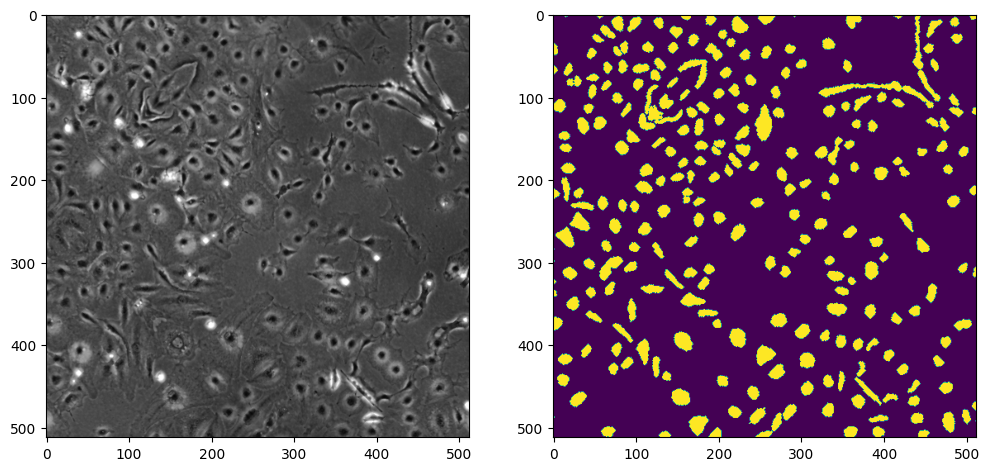

In [6]:
t = test_img_generator.next()
m = test_mask_generator.next()
for i in range(0,1):
    image = t[i]
    mask = m[i]
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

1/1 [==============================] - 3s 3s/step


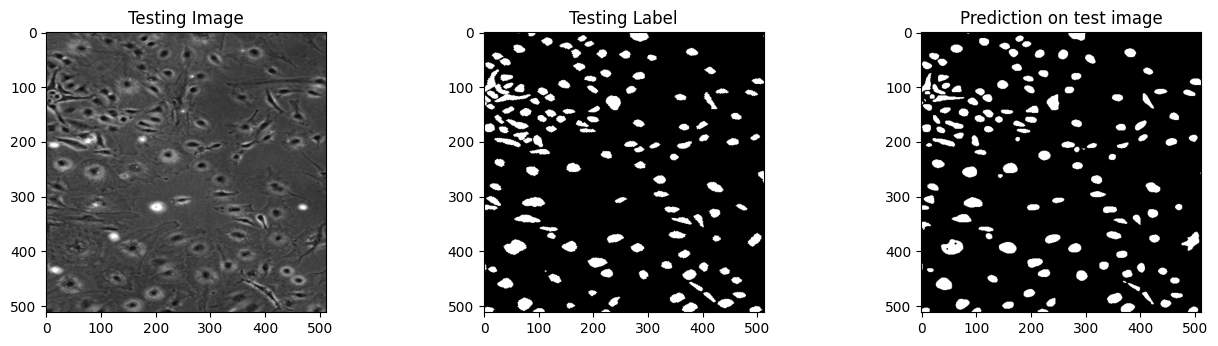

In [7]:
import random
test_img_number = random.randint(0, t.shape[0]-1)
test_img = t[test_img_number]
ground_truth= m[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()

In [8]:
def greytobinary(originalImage):
    
    #im_gray = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
    im_gray = originalImage
    thresh = 0
    blackAndWhiteImage = cv2.threshold(im_gray, thresh, 1, cv2.THRESH_BINARY)[1]
    # (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
    
    return blackAndWhiteImage

def Metrics_2(Y_pred,Y_val):
    import seaborn as sns

    FP = len(np.where(Y_pred - Y_val == -1)[0])
    FN = len(np.where(Y_pred - Y_val == 1)[0])
    TP = len(np.where(Y_pred + Y_val == 2)[0])
    TN = len(np.where(Y_pred + Y_val == 0)[0])
    
    Recall = TP/(TP+FN)
    Precision = TP/(TP+FP)
    Accuracy = (TP+TN)/(TP+FN+TN+FP)
    F1 = 2 * (Precision * Recall)/(Precision + Recall)
    IoU =  TP/(TP+FP+FN)
    DICE = (2 * TP) / (2 * TP+FP+FN)
    return Recall,Precision,Accuracy,F1,IoU, TP, TN, FP, FN,DICE


In [9]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import cv2

total_result = pd.DataFrame()
data=[]
from statistics import mean
#IoU_values = []
for img in range(0, t.shape[0]):
  temp_img = t[img]
  ground_truth=m[img]
  temp_img_input=np.expand_dims(temp_img, 0)
  prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.55).astype(np.uint8)

  Y_pred = prediction  
  Y_val = greytobinary(ground_truth)
  Y_val = np.reshape(Y_val,(512,512))
  #greytobinary(ground_truth)
  #print(Y_val)
  Y_val = Y_val.astype(int)
  #print(Y_val)
  Y_pred = 1 - Y_pred
  Y_val  = 1 - Y_val

  Recall, Precision, Accuracy, F1, IoU, TP, TN, FP, FN, DICE = Metrics_2(Y_pred,Y_val)
  #print(result.results)
  keys = ['Recall', 'Precision', 'Accuracy', 'F1','IoU', 'TP', 'TN', 'FP', 'FN', 'DICE']
  #keys = ['Recall', 'Precision', 'Accuracy', 'F1','IoU']
  values = [Recall, Precision, Accuracy, F1, IoU, TP, TN, FP, FN, DICE]
  #values = [result.Recall, result.Precision, result.Accuracy, result.F1, result.IoU]

  zipped = zip(keys, values)
  dic = dict(zipped)
  data.append(dic)
  total_result = total_result.append(data, True)

print("\nMean of Recall is: %f\nMean of Precision is: %f"%(mean(total_result['Recall']),mean(total_result['Precision']))) 
print("Mean of Accuracy is: %f\nMean of F1 is: %f\n"%(mean(total_result['Accuracy']),mean(total_result['F1'])))
print("\nMean of IoU is: %f"%(mean(total_result['IoU'])))
print("\nMean of DICE is: %f"%(mean(total_result['DICE'])))


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


1/1 [==============================] - 3s 3s/step

Mean of Recall is: 0.957725
Mean of Precision is: 0.992106
Mean of Accuracy is: 0.954684
Mean of F1 is: 0.974570


Mean of IoU is: 0.950498

Mean of DICE is: 0.974570


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\3103324730.py:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  total_result = total_result.append(data, True)


In [10]:
import numpy as np
import cv2
import pandas as pd
import glob
import pickle
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage import measure, color, io
import os
import pandas as pd
from skimage import data, io
from skimage import data, io

#####Watershed 
def process_images(prediction):
  #img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/output3.png")  #Read as color (3 channels)
  img_grey = prediction
  #img_grey = prediction[:,:,0]
  
# change the unet result to binary image
# Threshold image to binary using OTSU. All thresholded pixels will be set to 255
  ret1, thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#plt.imshow(thresh, cmap = 'gray')
# Morphological operations to remove small noise - opening
# To remove holes we can use closing
  kernel = np.ones((3,3),np.uint8)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
#plt.imshow(opening, cmap = 'gray')

#Watershed should find this area (Sure_Background) for us. 
  sure_bg = cv2.dilate(opening,kernel,iterations=10)
  #plt.imshow(sure_bg, cmap = 'gray')

# extract sure foreground area using distance transform and thresholding
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

# threshold the dist transform by starting at 1/2 its max value.
  ret2, sure_fg = cv2.threshold(dist_transform, 0.48 *dist_transform.max(),255,0)

# Unknown  region will calculate according to bkground - foreground
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)


# For sure regions,  foreground and background will be consider and kabel with positive numbers.
# Unknown regions will be labeled 0. 
  ret3, markers = cv2.connectedComponents(sure_fg)

# add 10 to all labels so that sure background will be consider as 10
  markers = markers+10

# Now, mark the region of unknown with zero
  markers[unknown==255] = 0
  prediction = cv2.cvtColor(prediction, cv2.COLOR_GRAY2BGR)
#plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.
 
  markers = cv2.watershed(prediction, markers)
  #plt.imshow(markers, cmap='gray')

#boundary region will be marked -1
#color boundaries in yellow. 
  prediction[markers == -1] = [0,255,255]  

  processed = color.label2rgb(markers, bg_label=0)

  props = measure.regionprops_table(markers, intensity_image=img_grey, 
                              properties=['label',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])
    
  df = pd.DataFrame(props)
  df = df[df.mean_intensity > 100]  
  #print(dataf.head())
  return df, processed

1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\2033427106.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  measurment = measurment.append(result_table)


,label,area,equivalent_diameter,mean_intensity,solidity


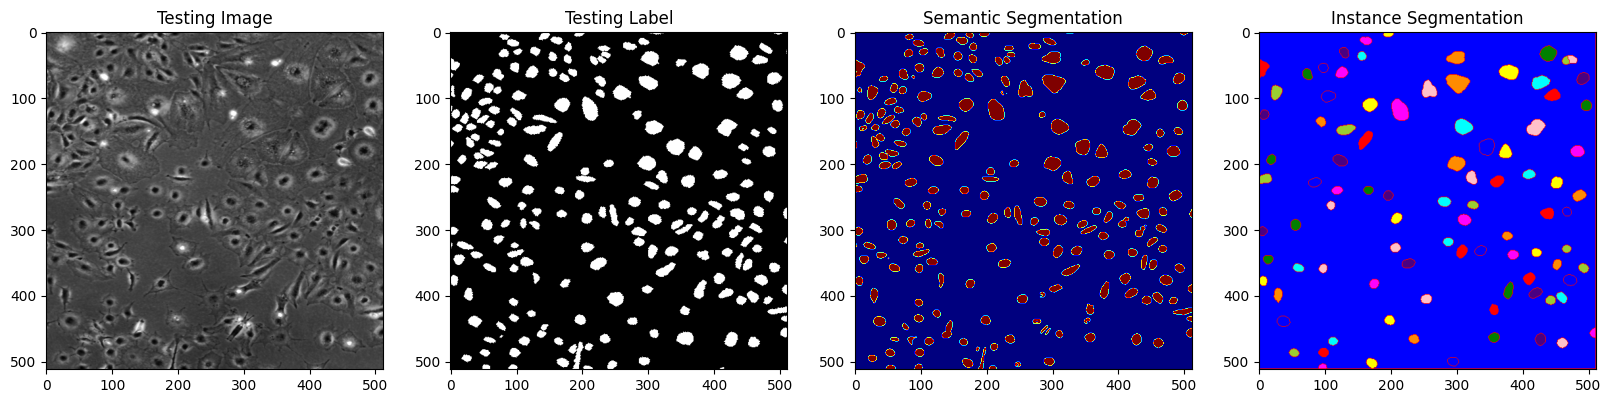

In [11]:
import random
measurment = pd.DataFrame([])
test_img_number = random.randint(0, t.shape[0]-1)
test_img = t[test_img_number]
ground_truth= m[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
# prediction = prediction
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
result_table, processed_img = process_images(prediction)
measurment = measurment.append(result_table)
org_1 = test_img
display (measurment)
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(1,4,2)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(1,4,3)
plt.title('Semantic Segmentation')
plt.imshow(prediction, cmap='jet')
plt.subplot(1,4,4)
plt.title('Instance Segmentation')
plt.imshow(processed_img, cmap='jet')
plt.show()

1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\2033427106.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  measurment = measurment.append(result_table)


,label,area,equivalent_diameter,mean_intensity,solidity


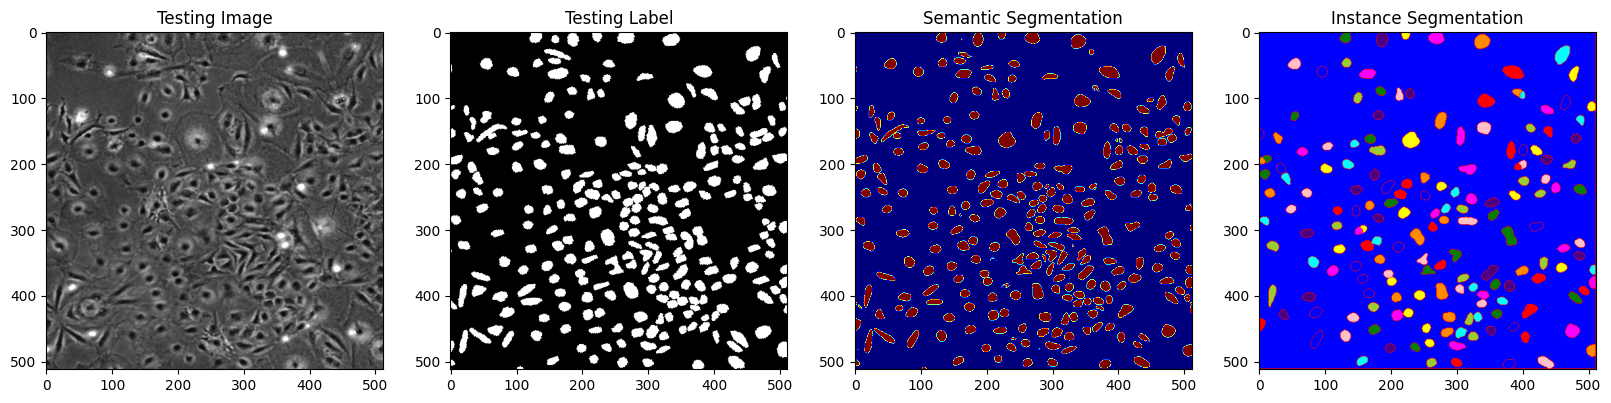

In [12]:
import random
measurment = pd.DataFrame([])
test_img_number = random.randint(0, t.shape[0]-1)
test_img = t[test_img_number]
ground_truth= m[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
# prediction = prediction
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)
result_table, processed_img = process_images(prediction)
measurment = measurment.append(result_table)
org_1 = test_img
display (measurment)
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(1,4,2)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(1,4,3)
plt.title('Semantic Segmentation')
plt.imshow(prediction, cmap='jet')
plt.subplot(1,4,4)
plt.title('Instance Segmentation')
plt.imshow(processed_img, cmap='jet')
plt.show()

1/1 [==============================] - 3s 3s/step


C:\Users\JOVIALN\AppData\Local\Temp\ipykernel_14828\2643169168.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  measurment = measurment.append(result_table)


,label,area,equivalent_diameter,mean_intensity,solidity


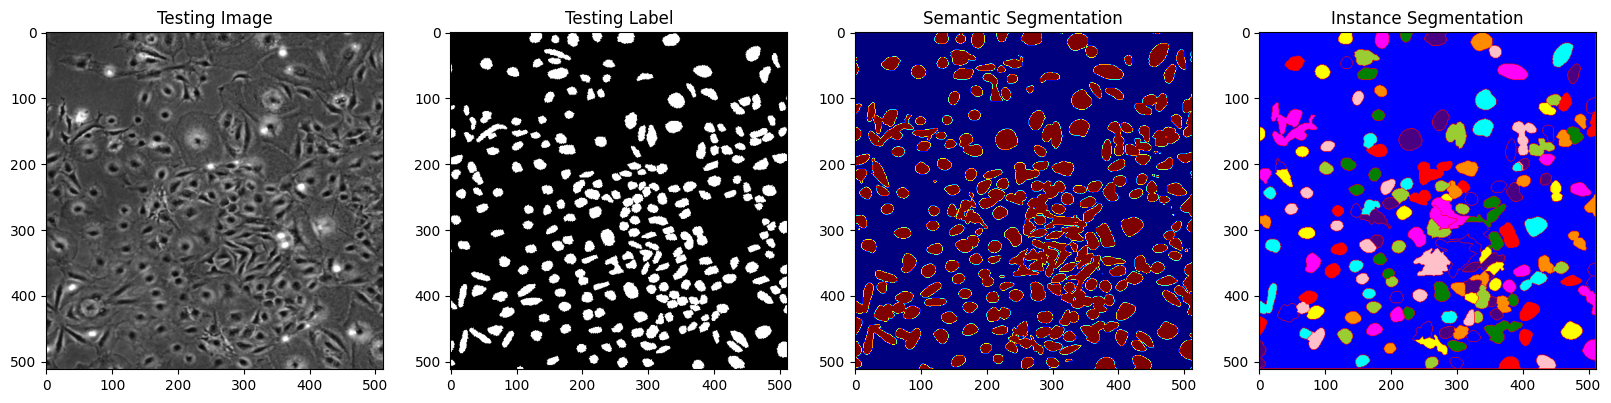

In [13]:
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.3).astype(np.uint8)
result_table, processed_img = process_images(prediction)
measurment = measurment.append(result_table)
display (measurment)
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(1,4,2)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(1,4,3)
plt.title('Semantic Segmentation')
plt.imshow(prediction, cmap='jet')
plt.subplot(1,4,4)
plt.title('Instance Segmentation')
plt.imshow(processed_img, cmap='jet')
plt.show()

1/1 [==============================] - 4s 4s/step


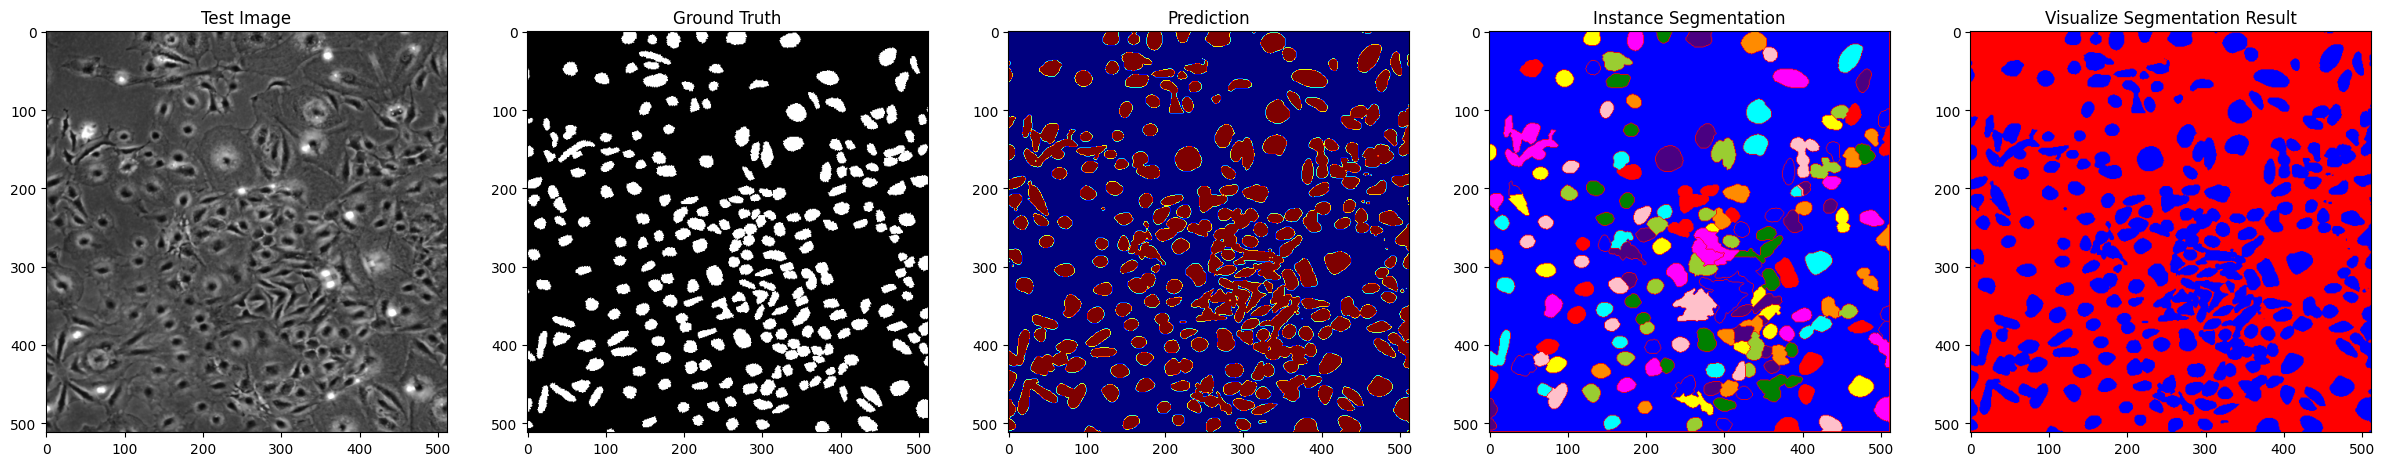

In [14]:
import random
import cv2
import glob
import os
import math
import numpy as np
import cv2
import pandas as pd
import pandas as pd
from skimage import io, color
import matplotlib.pyplot as plt
#main_color = cv2.imread(org_img_dir,cv2.IMREAD_COLOR)
# io.imshow(color.label2rgb(seg_visual,main,colors=[(255,0,0),(0,0,255)],alpha=0.01, bg_label=0, bg_color=None))
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.3).astype(np.uint8)
seg_visual = np.zeros((512,512)) # create a matrix of zeroes of same size as image
# Load images as greyscale but make main RGB so we can annotate in colour
seg = prediction
seg_visual[seg == 1] = 1   # Change zeroes to label "1" as per your condition(s)
seg_visual[seg == 0] = 2  


test_img2 = test_img
main_color = test_img
#main = cv2.cvtColor(main,cv2.COLOR_GRAY2BGR)

#io.imshow(color.label2rgb(seg_visual,main_color,colors=[(255,0,0),(0,0,255)],alpha=0.1, bg_label=0, bg_color=None))
#plt.show()
#result = io.imshow(color.label2rgb(seg_visual,main_color,colors=[(255,0,0),(0,0,255)],alpha=0.001, bg_label=0, bg_color=None))
plt.imsave('Unetseg_res_2.png', color.label2rgb(seg_visual,alpha=0.001, bg_label=0, bg_color=None), cmap = plt.cm.gray)
result = cv2.imread('Unetseg_res_2.png')

#plt.show()

plt.figure(figsize=(30, 8))
plt.subplot(1,5,1)
plt.title('Test Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(1,5,2)
plt.title('Ground Truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(1,5,3) 
plt.title('Prediction')
plt.imshow(prediction, cmap='jet')
plt.subplot(1,5,4)
plt.title('Instance Segmentation')
plt.imshow(processed_img, cmap='jet')
#plt.show()
plt.subplot(1,5,5)
plt.title('Visualize Segmentation Result')
plt.imshow(result)
plt.show()
